In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
import matplotlib.colors as colors
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline
import ji_ji_primeIMRIPY
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
t = 13.78e9               #in units of yrs corresponding to t_0=13.78Gyr
yr = 3.154e7              # in units of seconds
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of seconds
ρ_m  = 4e19                #ρ_m=4e19 M☉ Gpc^-3
t_m = 13.78e9             #in units of yr 
σ_eq = 0.005



def merger_method_2(m_1, m_2, Δ_1, Δ_2, t_m, DM_halos_presence):
    
    if m_1 < 5:
        return 0
    
    if m_2 < 5:
        return 0
    
    else: #1
        
        def f_(m):
            return f*P(m)

        def f_b(m_1,m_2):
            return  f_(m_1)+f_(m_2)

        def λ(m_1, m_2, Δ_1, Δ_2, X): # λ_0
            return  X/(f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2))

        def PDF(m):
            return (P(m)/m)


        I = quad(PDF, m_min, m_max)             # Taking limits of the PBH mass from m_min M☉ to m_max M☉ instead of 
                                             # 0 to infinity.

        n_T = f * ρ_eq * I[0]                #n_T=f*ρ_eq∫(P(m)/m)*dm 

        def x̄(m_1,m_2,Δ_1,Δ_2):
            return (((3 * (m_1 + m_2))/(8 * π * ρ_eq * f_b(m_1,m_2) * np.sqrt(Δ_1 * Δ_2)))**(1/3))
    
        X = np.geomspace(X_min, X_max, 100000) 
        
        
        if DM_halos_presence == 'False':
            
            def a_initial(m_1, m_2, Δ_1, Δ_2, X):  # for x = x_bar 
                return (0.0965*λ(m_1,m_2,Δ_1,Δ_2, X) + 0.0165*(λ(m_1,m_2,Δ_1,Δ_2, X)**2)) * x̄(m_1,m_2,Δ_1,Δ_2) * (X**(1/3))


            def j_i(m_1,m_2,Δ_1,Δ_2, X):
                return (((85/3) * (G**3) * m_1 * m_2 * (m_1 + m_2) * t_m)/((a_initial(m_1, m_2, Δ_1, Δ_2, X)**4)* (c**5)))**(1/7)
            
            
            def j_i_prime(m_1,m_2,Δ_1,Δ_2, X):
                return (j_i(m_1,m_2,Δ_1,Δ_2, X) / (7 * t_m))
            
                
            j_initial = j_i(m_1,m_2,Δ_1,Δ_2, X) 
            j_initial_prime = j_i_prime(m_1,m_2,Δ_1,Δ_2, X)
            
            # Merger rate of  PBH binaries without halos for PBHs mass range of m_min M☉ - m_max M☉.
            def D(m_1, m_2, Δ_1, Δ_2, X):
                return ( 1 + 0.0443 * λ(m_1, m_2, Δ_1, Δ_2, X))/ np.sqrt(1 + 0.1709 * λ(m_1, m_2, Δ_1, Δ_2, X))

            
            def j_X(m_1, m_2, Δ_1, Δ_2, X):
                return 0.4108 * np.sqrt(f**2 + 1.1994 * (σ_eq**2)) * D(m_1, m_2, Δ_1, Δ_2, X) * (X/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2)))

            
            def γ_X(m_1,m_2,Δ_1,Δ_2, X):    
                 return j_initial/ j_X(m_1, m_2, Δ_1, Δ_2, X)

            
            def integrand(m_1,m_2,Δ_1,Δ_2, X):
                return j_initial_prime * (1/j_initial) * ((γ_X(m_1,m_2,Δ_1,Δ_2, X)**2)/ ((1 + (γ_X(m_1,m_2,Δ_1,Δ_2, X)**2))**(3/2))) * np.exp(- X * ((4*π)/3) * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T)

            
            return  (ρ_m/2) * (((f**2)* (m_1 + m_2))/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2))) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2) *   (np.trapz(integrand(m_1,m_2,Δ_1,Δ_2, X),X))
        
        
        else: #3
            beta = 0.75
            gamma  =  0.65
            delta = -0.89   
            m1_ref = 1      # in units of solar mass.
            m2_ref = 1e-3   # in units of solar mass.

            m = file['arr_0']
            b = file['arr_1']
            a_i_ref = file['arr_2']  # in units of pc
            
            def a_initial(m_1, m_2, Δ_1, Δ_2, X):  # for x = x_bar 
                return (0.0977*λ(m_1,m_2,Δ_1,Δ_2, X) + 0.0057*(λ(m_1,m_2,Δ_1,Δ_2, X)**2)) * x̄(m_1,m_2,Δ_1,Δ_2) * (X**(1/3))


            def C(m_1,m_2,Δ_1,Δ_2, X):
                return ((a_initial(m_1,m_2,Δ_1,Δ_2, X)/a_i_ref)**(beta)) * ((m_1/ m1_ref)**(gamma)) * ((m_2/m2_ref)**(delta))
              
            
            
            C_list = (C(m_1,m_2,Δ_1,Δ_2, X)).tolist()
            j_initial_list = np.zeros(len(C_list))
            j_initial_prime_list  = np.zeros(len(C_list))
            
            
            for i, C in enumerate(C_list):
                variable = t_m/C
                
                if variable < tm_ref_list[0]:
                    
                    j_i = ji_ji_primeIMRIPY.ji_into_C_fitting_function(m, b, t_m) / (C**(1/m))   # t_m = (j_i**m) * (10**b)
                    j_i_prime = ji_ji_primeIMRIPY.ji_into_C_prime_fitting_function(m, b, t_m) / (C**(1/m)) 
                  
                elif tm_ref_list[0] < variable < tm_ref_list[-1]:
                    x = tm_ref_list
                    y = ji_ref_list
                    j_i = ji_ji_primeIMRIPY.ji_interpolation(x, y, variable)
                    j_i_prime = ji_ji_primeIMRIPY.ji_prime_into_C_interpolation(x, y, variable) / C
                
                else: 
                    
                    
                    j_i =   1    #Used as 1 instead of zero to avoid the divide by zero error in the integrand.                          
                    j_i_prime =   0                      
                
                
                j_initial_list[i]       =  j_i
                j_initial_prime_list[i] =  j_i_prime
                
            
            j_initial = np.array(j_initial_list) 
            j_initial_prime = np.array(j_initial_prime_list)
            
            
            def s(m_1, m_2, Δ_1, Δ_2, X): # S_dec of the binary decouple.
                return ((0.03095*λ(m_1, m_2, Δ_1, Δ_2, X)+ 0.3425)*λ(m_1, m_2, Δ_1, Δ_2, X))

            def t(m_1, m_2, Δ_1, Δ_2, X):  #t_dec of the binary decouple.
                return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(m_1, m_2, Δ_1, Δ_2, X)-2)*np.sqrt(s(m_1, m_2, Δ_1, Δ_2, X)+1))+(4/3)))


            def ρ_bar(m):
                return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 

            def M_halo(m, m_1, m_2, Δ_1, Δ_2, X):
                return (((16*π)/3)*ρ_bar(m)*((2 * G * m *(t(m_1, m_2, Δ_1, Δ_2, X)**2))**(1/4)))
 
            def M(m, m_1, m_2, Δ_1, Δ_2, X):
                return (m + M_halo(m, m_1, m_2, Δ_1, Δ_2, X))
   
            def M_binary_initial(m_1, m_2, Δ_1, Δ_2, X):
                return (m_1 + m_2 + M_halo(m_1, m_1, m_2, Δ_1, Δ_2, X) + M_halo(m_2, m_1, m_2, Δ_1, Δ_2, X))

                # Merger rate of  PBH binaries without halos for PBHs mass range of m_min M☉ - m_max M☉.
            def D_halo(m_1, m_2, Δ_1, Δ_2, X):
                return ( 1 + 0.0857 * λ(m_1, m_2, Δ_1, Δ_2, X))/ np.sqrt(1 + 0.0583 * λ(m_1, m_2, Δ_1, Δ_2, X))

            
            def j_X_halo(m_1, m_2, Δ_1, Δ_2, X):
                return 0.4087 * np.sqrt(f**2 + 0.2998 * (σ_eq**2)) * D_halo(m_1, m_2, Δ_1, Δ_2, X) * np.sqrt((m_1 + m_2)/ M_binary_initial(m_1, m_2, Δ_1, Δ_2, X)) * (X/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2)))

            
            def γ_X_halo(m_1,m_2,Δ_1,Δ_2, X):    
                return j_initial/ j_X_halo(m_1, m_2, Δ_1, Δ_2, X)

            
            
            def integrand_halo(m_1,m_2,Δ_1,Δ_2, X):
                return j_initial_prime * (1/j_initial) * ((γ_X_halo(m_1,m_2,Δ_1,Δ_2, X)**2)/ ((1 + (γ_X_halo(m_1,m_2,Δ_1,Δ_2, X)**2))**(3/2))) * np.exp(- X * ((4*π)/3) * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T)

            
            return  (ρ_m/2) * (((f**2)* (m_1 + m_2))/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2))) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2) *   (np.trapz(integrand_halo(m_1,m_2,Δ_1,Δ_2, X),X))       



In [10]:
m_1 = 7       #in units of M☉
m_2 = 9      #in units of M☉



y_1 = np.log(m_1)
y_2 = np.log(m_2)
dy = (y_2-y_1)


y_list = np.zeros(11)

for i in range(len(y_list)):
    y_list[i] = (y_1 + (i*dy))
    

M_1_list = np.zeros(len(y_list))
M_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    M_1_list[i] = (np.ceil(np.exp(y)))
    M_2_list[i] = (np.ceil(np.exp(y)))
    

            
m_1_list = [int(M_1) for M_1 in M_1_list]
m_2_list = [int(M_2) for M_2 in M_2_list]

    
Δ_1_list = np.zeros(len(y_list))
Δ_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    Δ_1_list[i] = np.exp(y + 0.5*dy) - np.exp(y - 0.5*dy)
    Δ_2_list[i] = np.exp(y + 0.5*dy) - np.exp(y - 0.5*dy) 

    
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)


m_min = 5     #in units of M☉
m_max = 100   # in units of M☉

X_min = 1e-6
X_max = 1e5

m_1 = [7, 10, 12, 15, 20, 25, 32, 41, 53, 68, 87] M☉

Δ_1 = [ 1.76383421  2.26778684  2.91572593  3.74879049  4.81987348  6.19698019
  7.96754596 10.24398767 13.17084129 16.9339388  21.77220702]


In [11]:
# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.

DM_halos_presence = 'False'
Merger_PWR1_nohalo_method_2 = np.zeros((11, 11))


merger_sum = 0
for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 3.19e-3
        f = 0.85*f_pbh
   
        def P(m):     #Powerlaw PBH mass distribution
            α = 1.6
            M = 5       #in units of M☉
            return ((α-1)/M) * ((m/M)**(-α))


        if i==j:
            Merger_PWR1_nohalo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_PWR1_nohalo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        if m_1 < m_2:
                
                merger_sum +=  0
        
        else:
                merger_sum +=  Merger_PWR1_nohalo_method_2[i,j]
            

print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
        
np.save("Merger_PWR1_nohalo_method_2", Merger_PWR1_nohalo_method_2)

Merger = 38.48559189401817 Gpc⁻3 yr⁻1


In [12]:
file = np.load('tm_ofj0_PWRhalo_1.npz')
m = file['arr_0']
b = file['arr_1']
a_i_ref =  file['arr_2']
ji_ref_list = file['arr_3']
tm_ref_list = file['arr_4']


# Calculation of the 2D merger rate for Power Law PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.

DM_halos_presence = 'True'
Merger_PWR1_halo_method_2 = np.zeros((11, 11))
merger_sum = 0


for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
     for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 3.19e-3
        f = 0.85*f_pbh
   
        def P(m):     #Powerlaw PBH mass distribution
            α = 1.6
            M = 5       #in units of M☉
            return ((α-1)/M) * ((m/M)**(-α))


        if i==j:
            Merger_PWR1_halo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_PWR1_halo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        if m_1 < m_2:
                
            merger_sum +=  0
        
        else:
            merger_sum +=  Merger_PWR1_halo_method_2[i,j]
            
            
            
print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
        
np.save("Merger_PWR1_halo_method_2", Merger_PWR1_halo_method_2)


Merger = -0.0027447293054231096 Gpc⁻3 yr⁻1


In [14]:
# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


DM_halos_presence = 'False'
Merger_Lognormal1_nohalo_method_2 = np.zeros((11, 11))



merger_sum = 0
for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 2.23e-3
        f = 0.85*f_pbh
   
        def P(m):                  #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉, for PBHs mass range of m_min = 5 M☉ - m_max = 100 M☉ .
            return  (1/(σ * m * np.sqrt(2*π))) * np.exp(-(((np.log(m/m_c))**2)/(2*(σ**2))))


        if i==j:
            Merger_Lognormal1_nohalo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_Lognormal1_nohalo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        
        if m_1 < m_2:
                
                merger_sum +=  0
        
        else:
                merger_sum +=  Merger_Lognormal1_nohalo_method_2[i,j]
            


print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_Lognormal1_nohalo_method_2", Merger_Lognormal1_nohalo_method_2)

Merger = 38.47187303372644 Gpc⁻3 yr⁻1


In [15]:
file = np.load('tm_ofj0_Lgnmlhalo_1.npz')
m = file['arr_0']
b = file['arr_1']
a_i_ref =  file['arr_2']
ji_ref_list = file['arr_3']
tm_ref_list = file['arr_4']




# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


DM_halos_presence = 'True'
Merger_Lognormal1_halo_method_2 = np.zeros((11, 11))



merger_sum = 0
for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 2.23e-3
        f = 0.85*f_pbh
   
        def P(m):                  #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉, for PBHs mass range of m_min = 5 M☉ - m_max = 100 M☉ .
            return  (1/(σ * m * np.sqrt(2*π))) * np.exp(-(((np.log(m/m_c))**2)/(2*(σ**2))))


        if i==j:
            Merger_Lognormal1_halo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_Lognormal1_halo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        if m_1 < m_2:
                
                merger_sum +=  0
        
        else:
                merger_sum +=  Merger_Lognormal1_halo_method_2[i,j]
            

            
            
            
print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_Lognormal1_halo_method_2", Merger_Lognormal1_halo_method_2)

Merger = 0.09678541729706477 Gpc⁻3 yr⁻1


In [ ]:
# Merger rates for the wider range of PBH masses from m_min = 1e-3 M☉ - m_max = 100 M☉. 

In [2]:
bin_centres = np.geomspace(1e-2, 96, 11)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])


ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 

#Now we can calculate deltas:
deltas = np.diff(bin_edges)




Δ_1_list = deltas.tolist()
Δ_2_list = deltas.tolist()



m_1 = np.geomspace(1e-2, 96, 11)
m_2 = np.geomspace(1e-2, 96, 11)


m_1_list = m_1.tolist()
m_2_list = m_2.tolist()   
    


m_1_list = list(map(lambda x: float(format(x, '.2f')), m_1_list))   
m_2_list = list(map(lambda x: float(format(x, '.2f')), m_2_list)) 




m_1_list = [0.01, 0.03, 0.06, 0.2, 0.4, 1, 3, 7, 16, 39, 96] 
m_2_list = [0.01, 0.03, 0.06, 0.2, 0.4, 1, 3, 7, 16, 39, 96]



Δ_1_list = list(map(lambda x: float(format(x, '.8f')),  Δ_1_list))   
Δ_2_list = list(map(lambda x: float(format(x, '.8f')),  Δ_2_list)) 
    

print('\v')
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)


m_min = 1e-3  #in units of M☉
m_max = 100   #in units of M☉

X_min = 3e-7
X_max = 1e5


m_1 = [0.01, 0.03, 0.06, 0.2, 0.4, 1, 3, 7, 16, 39, 96] M☉

Δ_1 = [0.00949415, 0.02375107, 0.05941695, 0.14864061, 0.37184728, 0.93023298, 2.32712042, 5.82164849, 14.56374623, 36.43344398, 91.14384576]


In [3]:
# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.

DM_halos_presence = 'False'
Merger_PWR2_nohalo_method_2 = np.zeros((11, 11))


merger_sum = 0
for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 3.19e-3
        f = 0.85*f_pbh
   
        def P(m):     #Powerlaw PBH mass distribution
            α = 1.6
            M = 1e-3      #in units of M☉
            return ((α-1)/M) * ((m/M)**(-α))


        if i==j:
            Merger_PWR2_nohalo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_PWR2_nohalo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        
        if m_1 < m_2:
            
            merger_sum += 0
        
        else:
            merger_sum += Merger_PWR2_nohalo_method_2[i,j]


        
print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_PWR2_nohalo_method_2", Merger_PWR2_nohalo_method_2)

Merger = 1.7202818433738816e-05 Gpc⁻3 yr⁻1


In [6]:
file = np.load('tm_ofj0_PWRhalo_2.npz')
m = file['arr_0']
b = file['arr_1']
a_i_ref =  file['arr_2']
ji_ref_list = file['arr_3']
tm_ref_list = file['arr_4']


# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.

DM_halos_presence = 'True'
Merger_PWR2_halo_method_2 = np.zeros((11, 11))
merger_sum = 0


for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 3.19e-3
        f = 0.85*f_pbh
   
        def P(m):     #Powerlaw PBH mass distribution
            α = 1.6
            M = 1e-3      #in units of M☉
            return ((α-1)/M) * ((m/M)**(-α))


        if i==j:
            Merger_PWR2_halo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_PWR2_halo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        if m_1 < m_2:
            
            merger_sum += 0
        
        else:
            merger_sum += Merger_PWR2_halo_method_2[i,j]



        
        
print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_PWR2_halo_method_2", Merger_PWR2_halo_method_2)

Merger = 0.0 Gpc⁻3 yr⁻1


In [7]:
# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


DM_halos_presence = 'False'
Merger_Lognormal2_nohalo_method_2 = np.zeros((11, 11))
merger_sum = 0



for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 1.91e-3
        f = 0.85*f_pbh
   
        def P(m):                  #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉, for PBHs mass range of m_min = 5 M☉ - m_max = 100 M☉ .
            return  (1/(σ * m * np.sqrt(2*π))) * np.exp(-(((np.log(m/m_c))**2)/(2*(σ**2))))


        if i==j:
            Merger_Lognormal2_nohalo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_Lognormal2_nohalo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        if m_1 < m_2:
            
            merger_sum += 0
        
        else:
            merger_sum += Merger_Lognormal2_nohalo_method_2[i,j]


            
            
print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_Lognormal2_nohalo_method_2", Merger_Lognormal2_nohalo_method_2)

Merger = 43.15031130352083 Gpc⁻3 yr⁻1


In [9]:
 # for the PBH mass range of 1e-3 - 100 solar mass.



file = np.load('tm_ofj0_Lgnmlhalo_2.npz')
m = file['arr_0']
b = file['arr_1']
a_i_ref =  file['arr_2']
ji_ref_list = file['arr_3']
tm_ref_list = file['arr_4']




# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


DM_halos_presence = 'True'
Merger_Lognormal2_halo_method_2 = np.zeros((11, 11))



merger_sum = 0
for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 1.91e-3
        f = 0.85*f_pbh
   
        def P(m):                  #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉, for PBHs mass range of m_min = 5 M☉ - m_max = 100 M☉ .
            return  (1/(σ * m * np.sqrt(2*π))) * np.exp(-(((np.log(m/m_c))**2)/(2*(σ**2))))


        if i==j:
            Merger_Lognormal2_halo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_Lognormal2_halo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        if m_1 < m_2:
            merger_sum +=  0
        
        else:
            merger_sum += Merger_Lognormal2_halo_method_2[i, j]
                
        

print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
        


np.save("Merger_Lognormal2_halo_method_2", Merger_Lognormal2_halo_method_2)

Merger = 0.5176721766223427 Gpc⁻3 yr⁻1


In [ ]:
# Merger rates plots for the range of PBH masses from m_min = 5 M☉ - m_max = 100 M☉. 

In [1]:
# Plots of the merger rate for PBH mass range of (5 - 100) solar mass.
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
import matplotlib.colors as colors
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib.colors import LogNorm
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


m_1 = 7       #in units of M☉
m_2 = 9      #in units of M☉



y_1 = np.log(m_1)
y_2 = np.log(m_2)
dy = (y_2-y_1)


y_list = np.zeros(11)

for i in range(len(y_list)):
    y_list[i] = (y_1 + (i*dy))
    

M_1_list = np.zeros(len(y_list))
M_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    M_1_list[i] = (np.ceil(np.exp(y)))
    M_2_list[i] = (np.ceil(np.exp(y)))
    

            
m_1_list = [int(M_1) for M_1 in M_1_list]
m_2_list = [int(M_2) for M_2 in M_2_list]

    
Δ_1_list = np.zeros(len(y_list))
Δ_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    Δ_1_list[i] = np.exp(y + 0.5*dy) - np.exp(y - 0.5*dy)
    Δ_2_list[i] = np.exp(y + 0.5*dy) - np.exp(y - 0.5*dy) 

    
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)

m_1 = [7, 10, 12, 15, 20, 25, 32, 41, 53, 68, 87] M☉

Δ_1 = [ 1.76383421  2.26778684  2.91572593  3.74879049  4.81987348  6.19698019
  7.96754596 10.24398767 13.17084129 16.9339388  21.77220702]


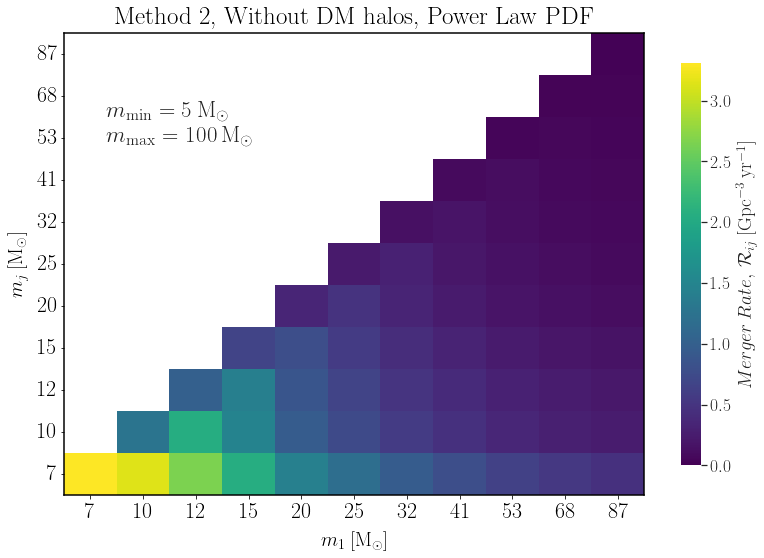

In [11]:
Merger_PWR1_nohalo_method_2 = np.load('Merger_PWR1_nohalo_method_2.npy')

mask = np.tril(np.ones((11,11)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(13, 8.5))  




sns.set(font_scale = 1.6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'


#vmin = 0.01
#vmax = np.max(Merger_PWR_nohalo_method_1)
#norm=LogNorm(vmin, vmax)


ax = sns.heatmap(Merger_PWR1_nohalo_method_2, mask = mask,  cmap = 'viridis', cbar = True,   
                 cbar_kws = { "shrink": 0.87, 'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                  vmin = 0)




ax.set_xticklabels(m_2_list, fontsize = 10)
ax.set_yticklabels(m_1_list, rotation = 360, fontsize = 10)
ax.tick_params(left = True,  bottom = True)

#ax.text(0.8, 9, "$X_\mathrm{min} = 10^{-5} \: \mathrm{M_{\odot}}$", size = 19)
#ax.text(0.8, 8.4, "$X_\mathrm{max} = 10^{5} \: \mathrm{M_{\odot}}$", size = 19)

ax.text(0.8, 9, "$m_\mathrm{{min}} = 5 \: \mathrm{M_{\odot}}$", size = 23)
ax.text(0.8, 8.4, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 23)


# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    
    
ax.invert_yaxis()
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.xlabel('$m_{1}\:[\mathrm{M_{\odot}}]$', fontsize = 20, labelpad = 9)     # m_j = m_2
plt.ylabel('$m_{j}\: [\mathrm{M_{\odot}}]$', fontsize = 20, labelpad = 9)    # m_i = m_1  and m_2 < equal to m_1.
plt.title('Method 2, Without DM halos, Power Law PDF', fontsize = 25, pad = 9)
plt.savefig('1imPWRLawnoDM.pdf', bbox_inches = 'tight')
plt.show()     

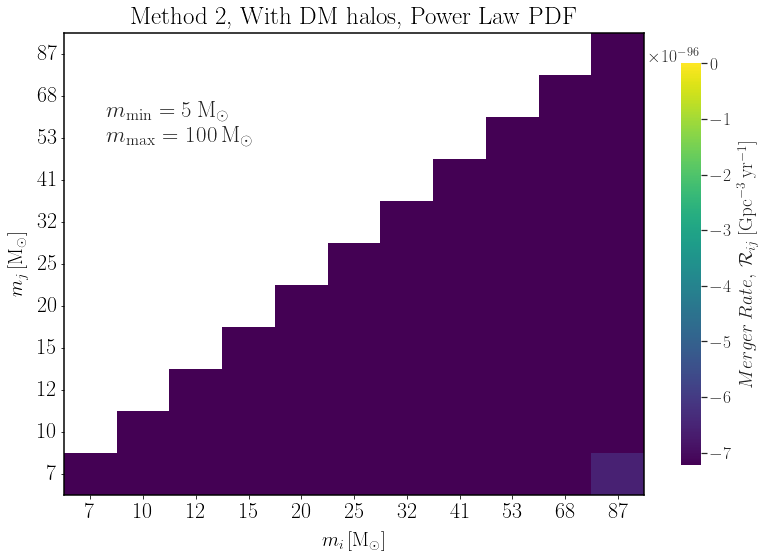

In [2]:
# Plot of merger rate for Power Law PBH mass function.

Merger_PWR1_halo_method_2 = np.load('Merger_PWR1_halo_method_2.npy')



mask = np.tril(np.ones((11,11)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize=(13, 8.5)) 



sns.set(font_scale = 1.6)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'

vmin = 0.01
vmax = np.max(Merger_PWR1_halo_method_2)
norm = LogNorm(vmin, vmax)

ax = sns.heatmap(Merger_PWR1_halo_method_2, mask = mask,  cmap = 'viridis', cbar = True,   
                 cbar_kws = {"shrink": 0.87,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 vmin = 0)


ax.set_xticklabels(m_1_list, fontsize = 10)
ax.set_yticklabels(m_2_list, rotation = 360, fontsize = 10)

#ax.text(0.8, 9, "$X_\mathrm{min} = 10^{-5} \: \mathrm{M_{\odot}}$", size = 19)
#ax.text(0.8, 8.4, "$X_\mathrm{max} = 10^{5} \: \mathrm{M_{\odot}}$", size = 19)

ax.text(0.8, 9, "$m_\mathrm{{min}} = 5 \: \mathrm{M_{\odot}}$", size = 23)
ax.text(0.8, 8.4, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 23)



# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    

ax.invert_yaxis()
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.xlabel('$m_{i}\,[\mathrm{M_{\odot}}]$', fontsize = 20, labelpad = 9)
plt.ylabel('$m_{j}\,[\mathrm{M_{\odot}}]$', fontsize = 20, labelpad = 9)
plt.title('Method 2, With DM halos, Power Law PDF', fontsize = 25, pad = 9)
plt.savefig('1imhPWRLawDM.pdf', bbox_inches = 'tight')
plt.show()    

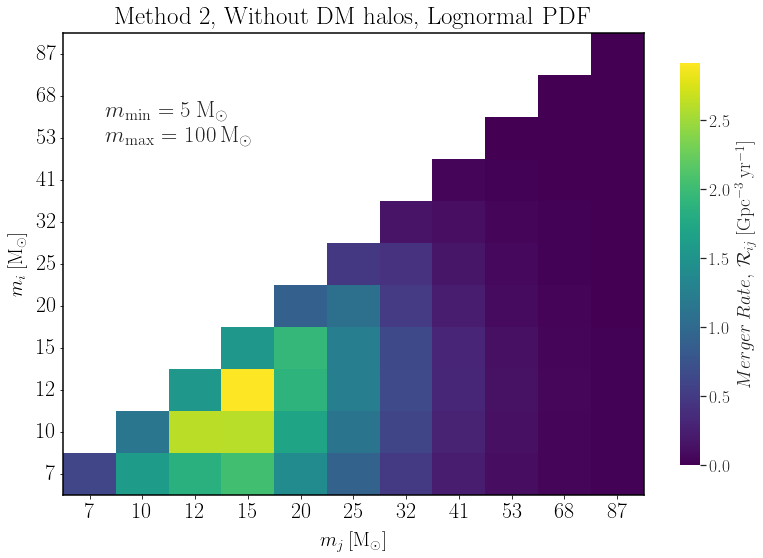

In [2]:
Merger_Lognormal1_nohalo_method_2 = np.load('Merger_Lognormal1_nohalo_method_2.npy')


mask = np.tril(np.ones((11, 11)),k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize = (13, 8.5))  


sns.set(font_scale = 1.6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'




vmin = 0.01
vmax = np.max(Merger_Lognormal1_nohalo_method_2)
norm=LogNorm(vmin, vmax)


ax = sns.heatmap(Merger_Lognormal1_nohalo_method_2, mask = mask,  cmap = 'viridis', cbar = True,
                 cbar_kws = {"shrink": 0.87,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                  vmin = 0)


ax.set_xticklabels(m_1_list, fontsize = 10)
ax.set_yticklabels(m_2_list, rotation = 360, fontsize = 10)
ax.tick_params(left = True, bottom = True)

#ax.text(0.8, 9, "$X_\mathrm{min} = 10^{-5} \: \mathrm{M_{\odot}}$", size = 19)
#ax.text(0.8, 8.4, "$X_\mathrm{max} = 10^{5} \: \mathrm{M_{\odot}}$", size = 19)

ax.text(0.8, 9, "$m_\mathrm{{min}} = 5 \: \mathrm{M_{\odot}}$", size = 23)
ax.text(0.8, 8.4, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 23)



# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)


ax.invert_yaxis()
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.xlabel('$m_{j}\: [\mathrm{M_{\odot}}]$', fontsize = 20, labelpad = 9)
plt.ylabel('$m_{i}\: [\mathrm{M_{\odot}}]$', fontsize = 20, labelpad = 9)
plt.title('Method 2, Without DM halos, Lognormal PDF', fontsize = 25, pad = 9)
plt.savefig('1imLogNormalnoDM.pdf', bbox_inches = 'tight')
plt.show()     

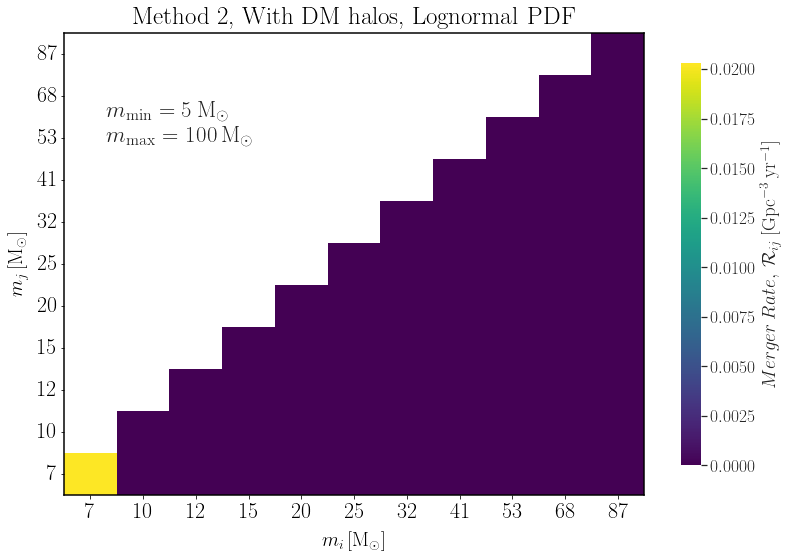

In [2]:
# Plot of merger rate for LogNormal PBH mass function.

Merger_Lognormal1_halo_method_2 = np.load('Merger_Lognormal1_halo_method_2.npy')


mask = np.tril(np.ones((11, 11)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize=(13, 8.5)) 


sns.set(font_scale = 1.6)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'


vmin = 0.01
vmax = np.max(Merger_Lognormal1_halo_method_2)
norm = LogNorm(vmin, vmax)


ax = sns.heatmap(Merger_Lognormal1_halo_method_2, mask = mask,  cmap = 'viridis', cbar = True,   
                 cbar_kws = {"shrink": 0.87,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                  vmin = 0)


 
ax.set_xticklabels(m_1_list, fontsize = 10)
ax.set_yticklabels(m_2_list, rotation = 360, fontsize = 10)

#ax.text(0.8, 9, "$X_\mathrm{min} = 10^{-5} \: \mathrm{M_{\odot}}$", size = 19)
#ax.text(0.8, 8.4, "$X_\mathrm{max} = 10^{5} \: \mathrm{M_{\odot}}$", size = 19)

ax.text(0.8, 9, "$m_\mathrm{{min}} = 5 \: \mathrm{M_{\odot}}$", size = 23)
ax.text(0.8, 8.4, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 23)


# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

    
ax.invert_yaxis()
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.xlabel('$m_{i}\,[\mathrm{M_{\odot}}]$', fontsize = 20, labelpad = 9 )
plt.ylabel('$m_{j}\,[\mathrm{M_{\odot}}]$', fontsize = 20, labelpad = 9)
plt.title('Method 2, With DM halos, Lognormal PDF', fontsize = 25, pad = 9)
plt.savefig('1imhLogNormalPDF.pdf', bbox_inches = 'tight')
plt.show()    

In [3]:
# Merger rates plots for the wider range of PBH masses from m_min = 1e-3 M☉ - m_max = 100 M☉. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
import matplotlib.colors as colors
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from scipy.interpolate import InterpolatedUnivariateSpline
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


bin_centres = np.geomspace(1e-2, 96, 11)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])


ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 


deltas = np.diff(bin_edges)




Δ_1_list = deltas.tolist()
Δ_2_list = deltas.tolist()



m_1 = np.geomspace(1e-2, 96, 11)
m_2 = np.geomspace(1e-2, 96, 11)


m_1_list = m_1.tolist()
m_2_list = m_2.tolist()   
    


m_1_list = list(map(lambda x: float(format(x, '.2f')), m_1_list))   
m_2_list = list(map(lambda x: float(format(x, '.2f')), m_2_list)) 




m_1_list = [0.01, 0.03, 0.06, 0.2, 0.4, 1, 3, 7, 16, 39, 96] 
m_2_list = [0.01, 0.03, 0.06, 0.2, 0.4, 1, 3, 7, 16, 39, 96]



Δ_1_list = list(map(lambda x: float(format(x, '.8f')),  Δ_1_list))   
Δ_2_list = list(map(lambda x: float(format(x, '.8f')),  Δ_2_list)) 
    

print('\v')
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)


m_1 = [0.01, 0.03, 0.06, 0.2, 0.4, 1, 3, 7, 16, 39, 96] M☉

Δ_1 = [0.00949415, 0.02375107, 0.05941695, 0.14864061, 0.37184728, 0.93023298, 2.32712042, 5.82164849, 14.56374623, 36.43344398, 91.14384576]


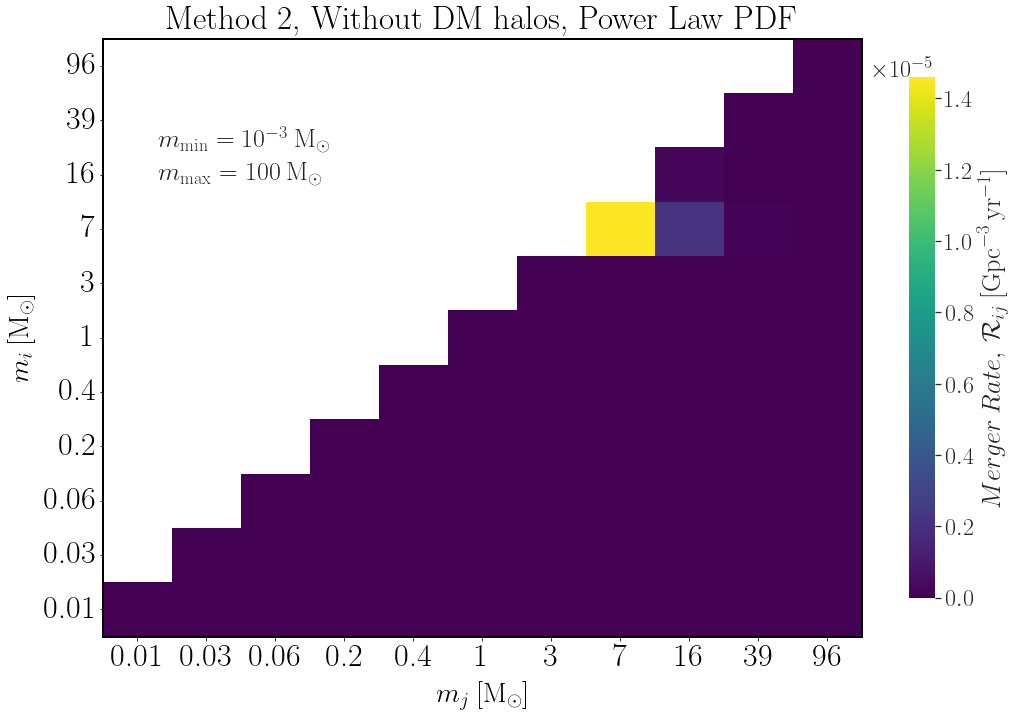

In [3]:
# Plot of merger rate for Power Law PBH mass function.

Merger_PWR2_nohalo_method_2 = np.load('Merger_PWR2_nohalo_method_2.npy')



mask = np.tril(np.ones((11, 11)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(17, 11))  


sns.set(font_scale = 2.2)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'


vmin = 1e-6
vmax = np.max(Merger_PWR2_nohalo_method_2)
norm = LogNorm(vmin, vmax)

ax = sns.heatmap(Merger_PWR2_nohalo_method_2, mask = mask,  cmap = 'viridis', cbar = True, 
                 cbar_kws = {"shrink": 0.87, 'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 fmt = '0.8f', vmin = 0)



ax.set_xticklabels(m_1_list, fontsize = 200)
ax.set_yticklabels(m_2_list,rotation = 360, fontsize = 200)
ax.tick_params(left=True, bottom=True)

#ax.text(0.8, 9, "$X_\mathrm{min} = 10^{-8} \: \mathrm{M_{\odot}}$", size = 24)
#ax.text(0.8, 8.4, "$X_\mathrm{max} = 10^{5} \: \mathrm{M_{\odot}}$", size = 24)

ax.text(0.8, 9, "$m_\mathrm{{min}} = 10^{-3} \: \mathrm{M_{\odot}}$", size = 26)
ax.text(0.8, 8.4, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 26)



# Drawing the frame
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)


ax.invert_yaxis()
plt.xticks(fontsize = 32)
plt.yticks(fontsize = 32)
plt.xlabel('$m_{j}\:[\mathrm{M_{\odot}}]$', fontsize = 28, labelpad = 9)   # m_j = m_2
plt.ylabel('$m_{i}\: [\mathrm{M_{\odot}}]$', fontsize = 28, labelpad = 9)  # m_i = m_1  and m_2< equal to m_1.
plt.title('Method 2, Without DM halos, Power Law PDF', fontsize = 33, pad = 9)
plt.savefig('2imPWRLawnoDM.pdf', bbox_inches = 'tight')
plt.show()     

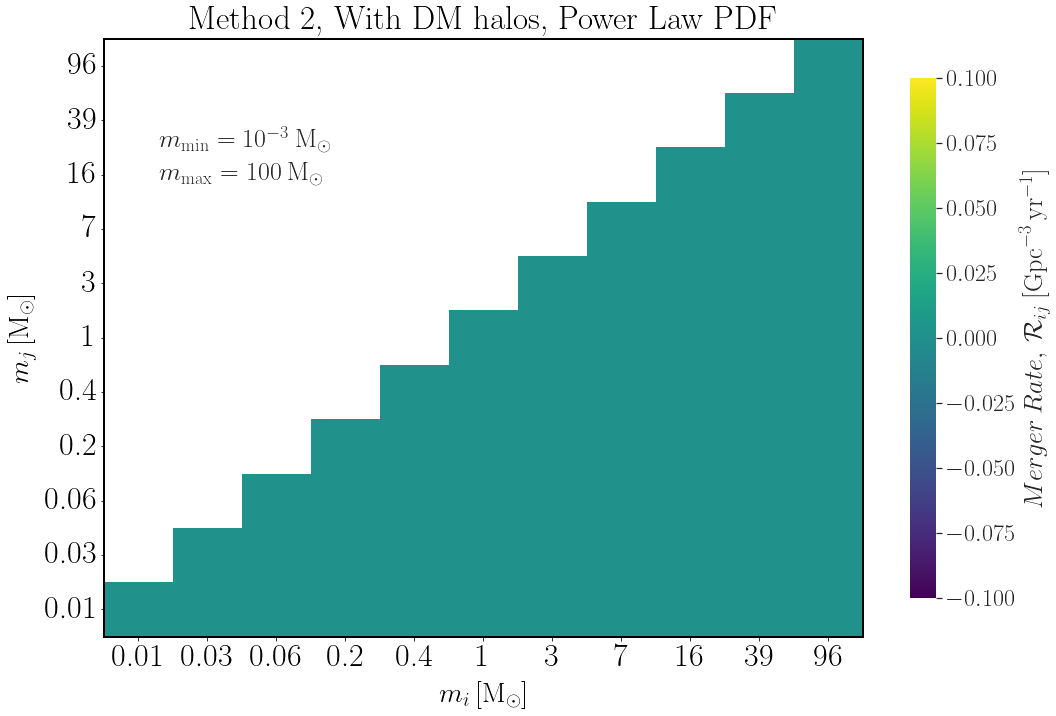

In [2]:
# Plot of merger rate for Power Law PBH mass function.



Merger_PWR2_halo_method_2 = np.load('Merger_PWR2_halo_method_2.npy')

mask = np.tril(np.ones((11,11)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize = (17, 11)) 


sns.set(font_scale = 2.2)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'

vmin = 1e-6
vmax = np.max(Merger_PWR2_halo_method_2)
norm = LogNorm(vmin, vmax)


ax = sns.heatmap(Merger_PWR2_halo_method_2, mask = mask,  cmap = 'viridis', cbar = True,  
                 cbar_kws = {"shrink": 0.87,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                   )




#ax.text(0.8, 9, "$X_\mathrm{min} = 10^{-8} \: \mathrm{M_{\odot}}$", size = 24)
#ax.text(0.8, 8.4, "$X_\mathrm{max} = 10^{5} \: \mathrm{M_{\odot}}$", size = 24)

ax.text(0.8, 9, "$m_\mathrm{{min}} = 10^{-3} \: \mathrm{M_{\odot}}$", size = 26)
ax.text(0.8, 8.4, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 26)


ax.set_xticklabels(m_1_list, fontsize = 200)
ax.set_yticklabels(m_2_list,rotation = 360, fontsize = 200)



# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    

ax.invert_yaxis()
plt.xticks(fontsize = 32)
plt.yticks(fontsize = 32)
plt.xlabel('$m_{i}\,[\mathrm{M_{\odot}}]$', fontsize = 28, labelpad = 9)
plt.ylabel('$m_{j}\,[\mathrm{M_{\odot}}]$', fontsize = 28, labelpad = 9)
plt.title('Method 2, With DM halos, Power Law PDF', fontsize = 33, pad = 9)
plt.savefig('2hPWRLawDM.pdf', bbox_inches = 'tight')
plt.show()    

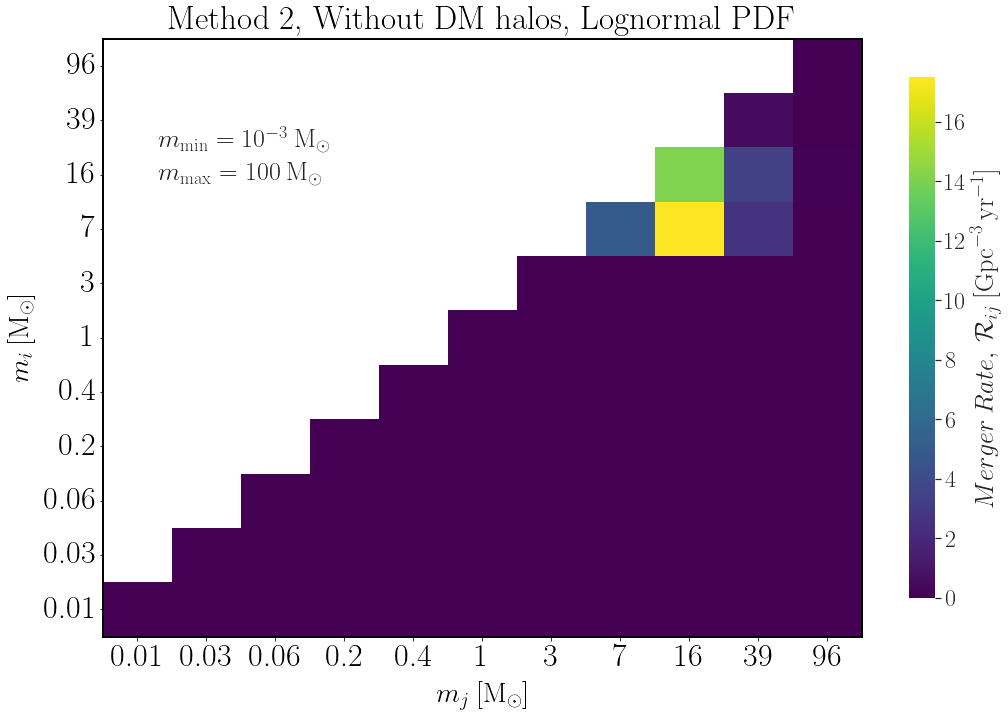

In [2]:
# Plot of merger rate for Lognormal PBH mass function.

Merger_Lognormal2_nohalo_method_2 = np.load('Merger_Lognormal2_nohalo_method_2.npy')


mask = np.tril(np.ones((11, 11)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize=(17, 11))  


sns.set(font_scale = 2.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

vmin = 0.1
vmax = np.max(Merger_Lognormal2_nohalo_method_2)
norm = LogNorm(vmin, vmax)

ax = sns.heatmap(Merger_Lognormal2_nohalo_method_2, mask = mask,  cmap = 'viridis', cbar = True, 
                 cbar_kws = {"shrink": 0.87,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 vmin = 0)


#ax.text(0.8, 9, "$X_\mathrm{min} = 10^{-8} \: \mathrm{M_{\odot}}$", size = 24)
#ax.text(0.8, 8.4, "$X_\mathrm{max} = 10^{5} \: \mathrm{M_{\odot}}$", size = 24)

ax.text(0.8, 9, "$m_\mathrm{{min}} = 10^{-3} \: \mathrm{M_{\odot}}$", size = 26)
ax.text(0.8, 8.4, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 26)



ax.set_xticklabels(m_1_list, fontsize = 200)
ax.set_yticklabels(m_2_list, rotation = 360, fontsize = 200)
ax.tick_params(left=True, bottom=True)



# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)

ax.invert_yaxis()
plt.xticks(fontsize = 32)
plt.yticks(fontsize = 32)
plt.xlabel('$m_{j}\: [\mathrm{M_{\odot}}]$', fontsize = 28, labelpad = 9)
plt.ylabel('$m_{i}\: [\mathrm{M_{\odot}}]$', fontsize = 28, labelpad = 9)
plt.title('Method 2, Without DM halos, Lognormal PDF', fontsize = 33, pad = 9)
plt.savefig('2LogNormalnoDM.pdf', bbox_inches = 'tight')
plt.show()     

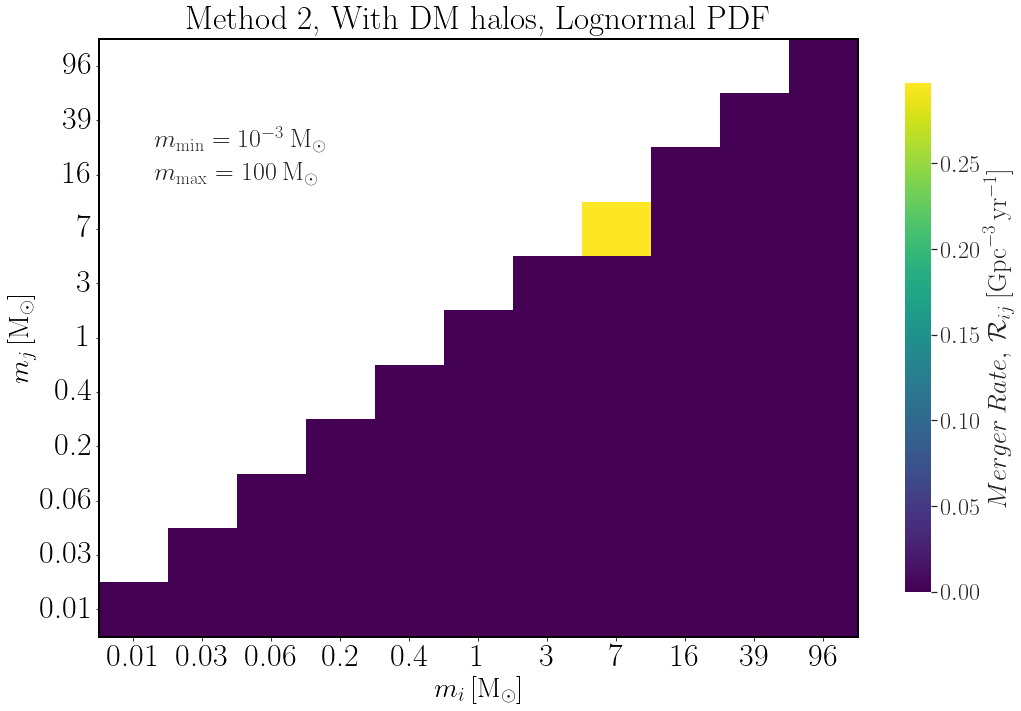

In [2]:
# Plot of merger rate for LogNormal PBH mass function.


Merger_Lognormal2_halo_method_2 = np.load('Merger_Lognormal2_halo_method_2.npy')


mask = np.tril(np.ones((11, 11)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize=(17, 11)) 

sns.set(font_scale = 2.2)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'


vmin = 1e-6
vmax = np.max(Merger_Lognormal2_halo_method_2)
norm = LogNorm(vmin, vmax)

ax = sns.heatmap(Merger_Lognormal2_halo_method_2, mask = mask,  cmap = 'viridis', cbar = True, 
                 cbar_kws = { "shrink": 0.85,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'}
                  )




#ax.text(0.8, 9, "$X_\mathrm{min} = 10^{-8} \: \mathrm{M_{\odot}}$", size = 24)
#ax.text(0.8, 8.4, "$X_\mathrm{max} = 10^{5} \: \mathrm{M_{\odot}}$", size = 24)

ax.text(0.8, 9, "$m_\mathrm{{min}} = 10^{-3} \: \mathrm{M_{\odot}}$", size = 26)
ax.text(0.8, 8.4, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 26)


ax.set_xticklabels(m_1_list, fontsize = 200)
ax.set_yticklabels(m_2_list, rotation = 360, fontsize = 200)




# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
   
    
    
ax.invert_yaxis()
plt.xticks(fontsize = 32)
plt.yticks(fontsize = 32)
plt.xlabel('$m_{i}\, [\mathrm{M_{\odot}}]$', fontsize = 28)
plt.ylabel('$m_{j}\, [\mathrm{M_{\odot}}]$', fontsize = 28)
plt.title('Method 2, With DM halos, Lognormal PDF', fontsize = 33, pad = 9)
plt.savefig('2imhLogNormalDM.pdf', bbox_inches = 'tight')
plt.show() 